# Braille detection with CNN

In this script we create, train and evaluate an image classifier based on convolutional networks.

In [233]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset, DataLoader
import fnmatch
from skimage import io, transform
import torchvision

# Define the device and data repository
device = 'cpu'
data_dir = 'archive/Braille Dataset/Braille Dataset/'

# Data management

We read data, split it onto train, val and test and create data loaders with preprocessing.

In [234]:
# We start by creating a class object for representing our image data
# This is a subclass of torch.utils.data.dataset.Dataset that will serve as input to the DataLoader

class ImageDataset(Dataset):

    def __init__(self, image_dir, transform=None):
        """Here we initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_files = sorted(self._find_files(image_dir))
        self.classes = [filename.split("/")[-1][0] for filename in self.image_files]
        self.let2num = {a: i for i, a in enumerate(sorted(list(set(self.classes))))}
        self.num2let = {i: a for a, i in self.let2num.items()}
        
        self.transform = transform
        
    def letter_to_number(self, let):
        return self.let2num[let]
    
    def number_to_letter(self, num):
        return self.num2let[num]
    

    def __len__(self):
        """Here we return the size of the dataset."""
        return len(self.image_files)

    def __getitem__(self, index):
        """Here we return a data sample for a given index."""
        # TO DO: write this function: it takes as input 'index' (which is an integer number),
        # and returns the corresponding item as a pytorch tensor
        # hint: use 'self.image_files' , which is the list of images paths defined in the '__init__' method
        filename = self.image_files[index]
        x = io.imread(filename)
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.classes[index]

    def _find_files(self, directory, pattern='*.jpg'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))
        return files


In [235]:
#to divide: torch.utils.data.random_split(dataset, lengths)
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(
                                                      mean=(0.5, 0.5, 0.5), 
                                                      std=(0.3,0.3,0.3))])

In [236]:
dataset = ImageDataset(image_dir=data_dir, transform=data_transforms)

In [237]:
len(set(dataset.classes))

26

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


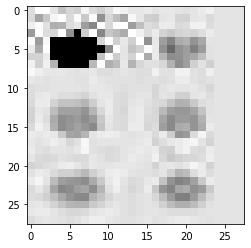

In [238]:
plt.imshow(dataset[0][0].numpy().transpose(1, 2, 0))

In [239]:
dataset[0][0].size()

torch.Size([3, 28, 28])

In [240]:
dataset.letter_to_number(dataset[0][1])

0

In [241]:
dataset.number_to_letter(0)

'a'

In [242]:
dataset_ln = len(dataset)
train_ln, val_ln, test_ln = int(dataset_ln * 0.8), int(dataset_ln * 0.1), int(dataset_ln * 0.1)

In [243]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_ln, val_ln, test_ln], generator=torch.Generator().manual_seed(42))

In [244]:
len(val_data)

156

In [245]:
val_data[1]

(tensor([[[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ...,

In [246]:
def collate_fn(data):
    images, labels = zip(*data)
    
    labels = [dataset.letter_to_number(label) for label in labels]
    return torch.stack(images).float(), torch.tensor(labels).long()


In [247]:
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)


# Model

Here we create several different models to compare


In [248]:
# Define a CNN classifier module.

class CNNSimpleClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        super(CNNSimpleClassif, self).__init__()
        

        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        self.res = nn.Linear(size_vec, num_classes)
    def forward(self, x):
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(x)
        return out

# Useful functions for training, validation and testing

In [249]:
def eval_model(model, eval_dataloader, device='cpu'):

    # Copy the model to the device
    model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels classes
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [250]:
def train_model(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name='simple'):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    last_best_acc = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            #print(labels)
            #print(images.size(), labels.size(), labels)
            images = images.to(device)
            labels = labels.to(device)
            
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            
            
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            loss_current_epoch += loss.item()
            
        cur_acc = eval_model(model, valid_dataloader)
        if cur_acc > last_best_acc:
            last_best_acc = cur_acc
            torch.save(model.state_dict(), f'model_{model_name}_best.pt')
            print("\nNew best accuracy! ", last_best_acc)
            
        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('\rEpoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch), end='')
        
    return model, loss_all_epochs

# Experiments

In [251]:
num_channels1 = 16
num_channels2 = 32
num_classes = 26
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)


New best accuracy!  40.38461538461539
Epoch [1/20], Loss: 441.1668
New best accuracy!  55.12820512820513
Epoch [2/20], Loss: 260.3588
New best accuracy!  56.41025641025641
Epoch [3/20], Loss: 183.4120
New best accuracy!  62.17948717948718
Epoch [4/20], Loss: 143.7706
New best accuracy!  69.23076923076923
Epoch [6/20], Loss: 92.86337
New best accuracy!  73.07692307692308
Epoch [7/20], Loss: 76.1755
New best accuracy!  73.71794871794872
Epoch [8/20], Loss: 60.7010
New best accuracy!  77.56410256410257
Epoch [13/20], Loss: 18.8131
New best accuracy!  82.05128205128206
Epoch [20/20], Loss: 3.60545

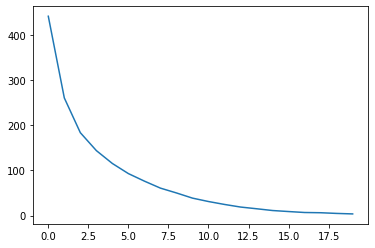

In [252]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'model_simple.pt')
plt.plot(loss_total)
plt.show()

In [253]:
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)

model.load_state_dict(torch.load('model_simple_best.pt'))

res = eval_model(model, test_dataloader, device='cpu')
print(res)

82.6923076923077
